
#### http://github.com/timestocome


## N-armed Bandits in N-casinos
### Adapted from Chpt 2 Deep Reinforcement Learning _in Action_

The book uses the same number of actions and states which isn't as clear as I'd like. So I changed it to have 10 actions(bandits) in 12 casinos(states) The pytorch network is a 2 layer Q network. 



In [1]:
# setup

import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt


n_bandits = 10
n_casinos = 12
probs = np.random.rand(n_bandits) 
eps = 0.1  # how often to randomly check other bandits instead of greedy choice

In [2]:
# use probability of reward from each bandit instead of raw rewards
# av running rewards
# tau == temperature, higher temp smooths probabilities, lower magnifies differences
# this is the policy function
def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm

In [3]:
# create  bandit class with n_bandits in n_casinos
# bandits are the action chosen 
# casinos are the state user is in

class ContextBandit:
    # setup n bandits
    def __init__(self, n_bandits, n_casinos):
        self.n_bandits = n_bandits
        self.n_casinos = n_casinos
        self.init_distribution(self.n_bandits, self.n_casinos)
        self.update_state()
        
    def init_distribution(self, n_bandits, n_casinos):
        
        #each row represents a state, each column an arm
        self.bandit_matrix = np.random.rand(n_casinos, n_bandits)
        
    def reward(self, prob):
        reward = 0
        for i in range(self.n_bandits):
            if random.random() < prob:
                reward += 1
        return reward
        
    # get casino
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0, self.n_casinos)
        
    def get_reward(self, bandit):
        return self.reward(self.bandit_matrix[self.get_state()][bandit])
        
    def choose_arm(self, bandit):
        reward = self.get_reward(bandit)
        self.update_state()
        return reward

In [4]:
# use pytorch to create 2 layer fully connected network

import numpy as np
import torch


# network 
n_in = n_bandits  # action
n_out = n_casinos # state
n_hidden = 100
N, D_in, H, D_out = 1, n_bandits, n_hidden, n_casinos 

In [5]:
env = ContextBandit(n_bandits, n_casinos)
state = env.get_state()
reward = env.choose_arm(1)
print(state)

5


In [6]:
# fully connected, relu network
model = torch.nn.Sequential(
    torch.nn.Linear(n_casinos, H),
    torch.nn.ReLU(),
    
    torch.nn.Linear(H, n_bandits),
    torch.nn.ReLU(),
)

In [7]:
# model loss is mean squared error
loss_fn = torch.nn.MSELoss()

In [8]:
# environment is matrix of [states, actions] ( casinos, bandits )
env = ContextBandit(n_bandits, n_casinos)

In [9]:
# utility to create one-hot vectors
def one_hot(N, pos, val=1):
    
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    
    return one_hot_vec

In [10]:
# N == number of running mean to use --- memory
def running_mean(x, N=50):
    
    c = x.shape[0] - N  # truncate to memory size
    y = np.zeros(c)     # create array of zeros
    conv = np.ones(N)   # create array of ones
    
    # for each reward calculate running average and store in y
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    
    return y

In [11]:

def train(env, epochs=5000, learning_rate=1e-2):

    # pre load current state and setup model
    cur_state = torch.Tensor(one_hot(n_casinos, env.get_state())) 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    
    
    for i in range(epochs):
    
        # get predicted reward for current_state (casino) and convert to probability
        y_pred = model(cur_state) 
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0) 
        av_softmax /= av_softmax.sum() 
        
        # pick a random bandit and collect reward
        choice = np.random.choice(n_bandits, p=av_softmax) 
        cur_reward = env.choose_arm(choice) 
        one_hot_reward = y_pred.data.numpy().copy() 
        one_hot_reward[choice] = cur_reward 
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        
        # compute loss for nn and update weights
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update current casino
        cur_state = torch.Tensor(one_hot(n_casinos, env.get_state())) 
        
    return np.array(rewards)

In [12]:
rewards = train(env)

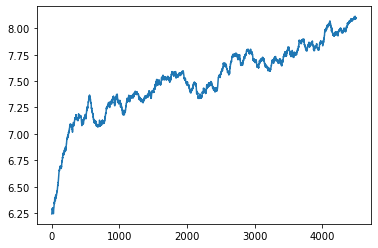

In [13]:
plt.plot(running_mean(rewards, N=500))